In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error

In [1]:
#Read NN and BMS data
n=8;id=0;function='tanh' #tanh, leaky_ReLU
NPAR=10 #5, 10, 20

#Read NN data
train_size=60
file_model='NN_model_' + function + '_train_' +str(train_size)+ '_NREP_10_data' + '.csv'
model_d='../data/' + file_model
d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)

#Read BMS data
filename='BMS_' + function + '_trace.' + str(n) + '_prior_'  + str(NPAR) + '_id_' + str(id) + '.csv'
#filename='BMS_long_' + function + '_trace.' + str(n) + '_prior_'  + str(NPAR) + '.csv'

print(filename) 
trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
display(trace)

NameError: name 'pd' is not defined

In [41]:
#Minimum description length
#minrow = trace[trace.H == max(trace.H)].iloc[0]
minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

print(minrow)
print(minH)
print(minexpr)
print(minparvals)

t                                                      12851
H                                                -327.161027
expr       (((((cosh((tanh((x1 * _a4_)) + _a6_)) ** _a3_)...
parvals    {'d0': {'_a0_': 0.943812086885277, '_a1_': 0.7...
kk1                           {'d0': 2.3108462949393913e-06}
kk2                                              -817.212753
kk3                                                81.445349
Name: 12851, dtype: object
-327.161027126379
(((((cosh((tanh((x1 * _a4_)) + _a6_)) ** _a3_) * (((x1 + _a3_) * _a5_) + _a7_)) + _a2_) ** (_a0_ ** x1)) / _a1_)
{'d0': {'_a0_': 0.943812086885277, '_a1_': 0.7598282023583552, '_a2_': -0.02459583381967414, '_a3_': 1.9547414376215886, '_a4_': 1.9359961585839647, '_a5_': 0.03182527891806763, '_a6_': 0.4582634649816992, '_a7_': 0.044100709970908744}}


In [42]:
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()
y = dn.y


if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')
elif NPAR==5:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np5.2017-10-18 18:07:35.227360.dat')
elif NPAR==3:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np3.2017-10-18 18:07:35.262530.dat')

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

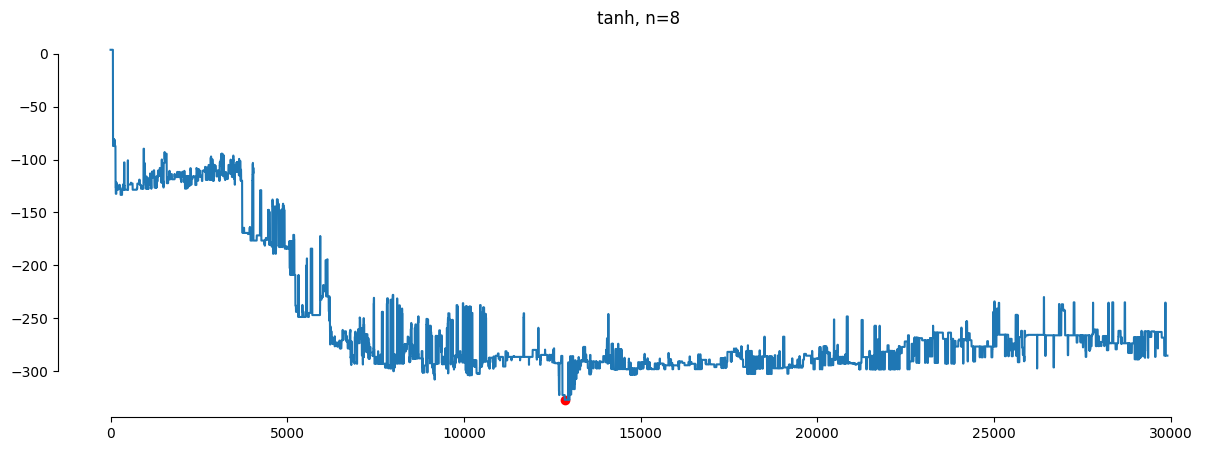

In [43]:
Nini = 00
plt.figure(figsize=(15, 5))

#Define figure size in cm                                                                           
Extensions=['.png']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                           
plt.title(str(function) + ', ' + 'n=' + str(n))
plt.plot(trace.t[trace.t > Nini], trace.H[trace.t > Nini])
plt.scatter(minrow['t'], minH,color='r')
#plt.plot(trace.t, trace.H)
sns.despine(trim=True)

Name_figure='Energy_' + function + '_' + str(n) + '_par_' + str(NPAR)
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

 
plt.show()

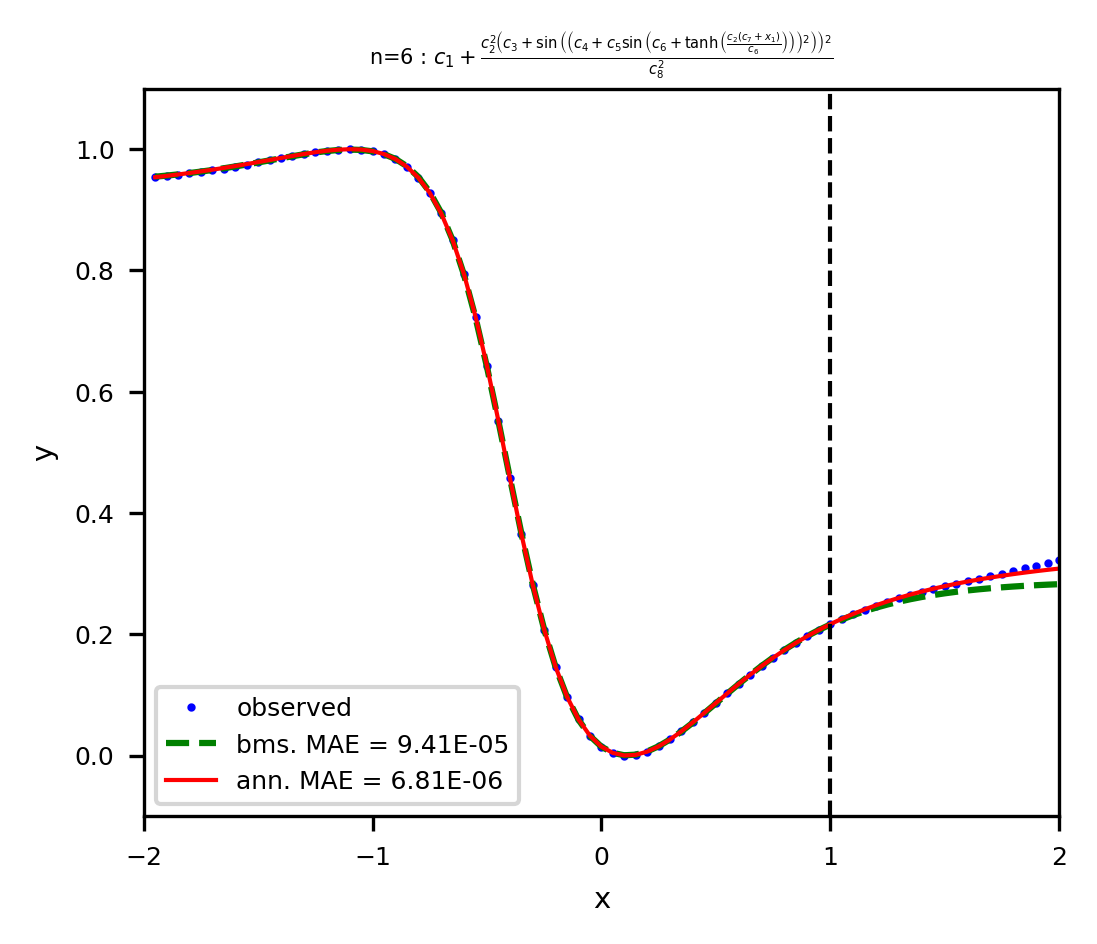

In [39]:
#Plot
train_border=dn.loc[train_size-1]['x1']

dplot = deepcopy(dn)
dplot['ybms'] = t.predict(x)

MAE_bms=mean_squared_error(dplot.ybms,dn.y)
MAE_nn=mean_squared_error(dplot.ymodel,dn.y)

#MAE_bms=mean_squared_error(dplot.loc[:train_size-1]['ybms'],dn.loc[:train_size-1]['y'])
#MAE_nn=mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dn.loc[:train_size-1]['y'])


 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          


fig=figure(figsize=(width,height), dpi=300)                                                        

plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed') 
plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='bms. MAE = %.2E' % MAE_bms)                                                   
plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann. MAE = %.2E' % MAE_nn)   

plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.title('n=%d : $%s$' % (n, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(-2,2);plt.ylim(-0.1,1.1)                                               

Name_figure='Prediction_mdl_' + function + '_' + str(n) + '_par_' + str(NPAR)
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

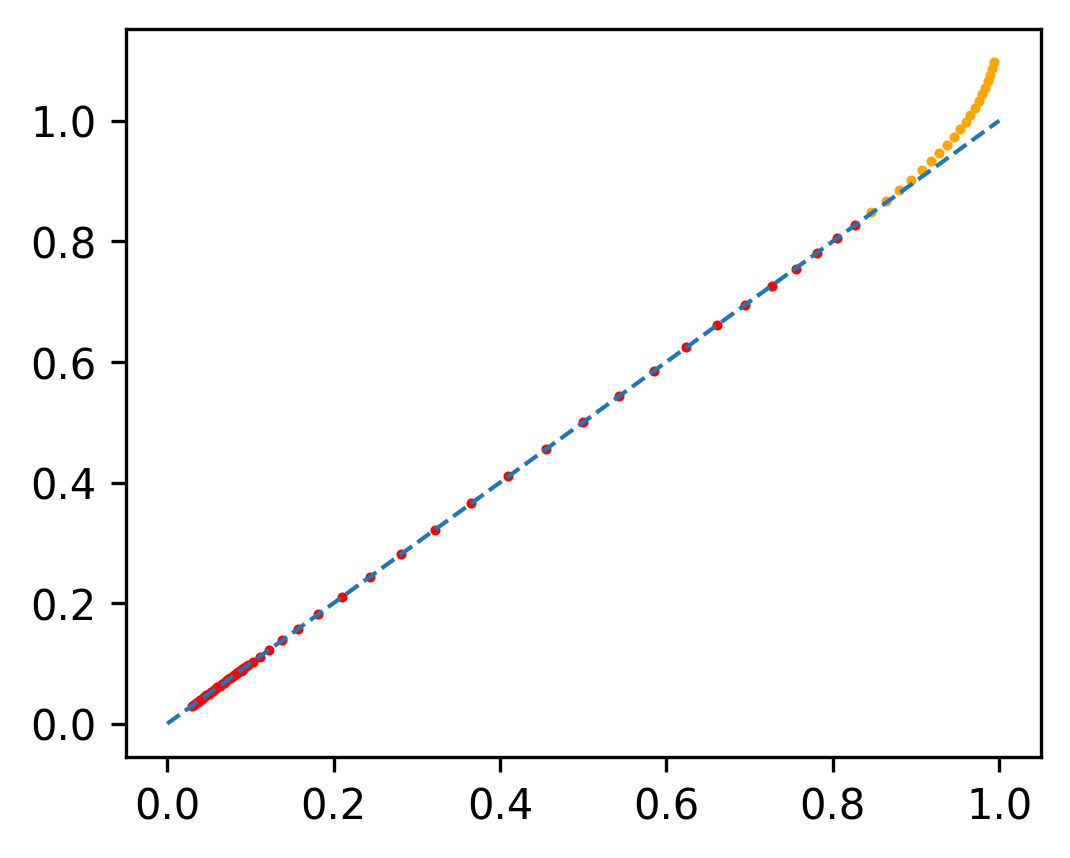

In [34]:
fig=figure(figsize=(width,height), dpi=300)

plt.plot([0,1], [0,1],linestyle='--',linewidth=line_w)
plt.scatter(dn.loc[:train_size-1]['y'],dplot.loc[:train_size-1]['ybms'] , s=marker_s-1, color='red',label='train')
plt.scatter(dn.loc[train_size:]['y'],dplot.loc[train_size:]['ybms'] , s=marker_s-1, color='orange',label='test')

plt.show()